In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.data import DataStore
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    FluxPointsDataset,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    SkyModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [2]:
plt.rcParams.update({
    'figure.figsize': (12, 9),
    'font.size': 15,
    'grid.linestyle': '--',
})

# Load DL3 data file

In [3]:
# === Settings ===
dl3_dir = '/home/yoshiki.ohtani/software/magic-cta-pipe/magicctapipe/scripts/lst1_magic/dl3_gam_global0.6/'

# === Main ===
datastore = DataStore.from_dir(dl3_dir)

obs_ids = datastore.obs_table['OBS_ID'].value
observations = datastore.get_observations(obs_ids, required_irf=['aeff', 'edisp'])

print(observations)

No HDU found matching: OBS_ID = 5093711, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093711, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093711, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093712, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093712, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093712, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093713, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093713, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093713, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093714, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093714, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093714, HDU_TYPE = rad_max, HDU_CLASS = None


Observations
Number of observations: 4
Observation

	obs id            : 5093711 
 	tstart            : 59198.89
	tstop             : 59198.90
	duration          : 864.68 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 0.0%
Observation

	obs id            : 5093712 
 	tstart            : 59198.90
	tstop             : 59198.91
	duration          : 846.19 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 0.0%
Observation

	obs id            : 5093713 
 	tstart            : 59198.92
	tstop             : 59198.93
	duration          : 816.03 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 0.0%
Observation

	obs id            : 5093714 
 	tstart            : 59198.93
	tstop             : 59198.94
	duration          : 776.30 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 0.0%



# Define a target region

In [4]:
# === Settings ===
target_source_name = 'Crab'

# target_source_lon = u.Quantity(83.63, u.deg)
# target_source_lat = u.Quantity(22.01, u.deg)
# target_source_frame = 'icrs'

# === Main ===
if target_source_name is not None:
    print(f'Get the target position from the source name: {target_source_name}\n')
    target_position = SkyCoord.from_name(target_source_name)
    target_position = target_position.transform_to('icrs')
else:
    print('Set the target position with the input values...\n')
    target_position = SkyCoord(target_source_lon, target_source_lat, frame=target_source_frame)
    
# Define an on-region radius.
# Here it assumes that the IRFs are created with a global theta cut:
base_dir = datastore.hdu_table[0].meta['BASE_DIR']
file_name = datastore.hdu_table[0]['FILE_NAME']

file_path = Path(base_dir) / Path(file_name)
on_region_radius = u.Quantity(Table.read(file_path, hdu='EFFECTIVE AREA').meta['RAD_MAX'], u.deg)

on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

print(on_region)

Get the target position from the source name: Crab

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>
radius: 0.2 deg


# Create an exclusion mask

Get the exclusion position from the source name: RGB J0521+212

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (80.44152391, 21.21429244)>
radius: 0.5 deg


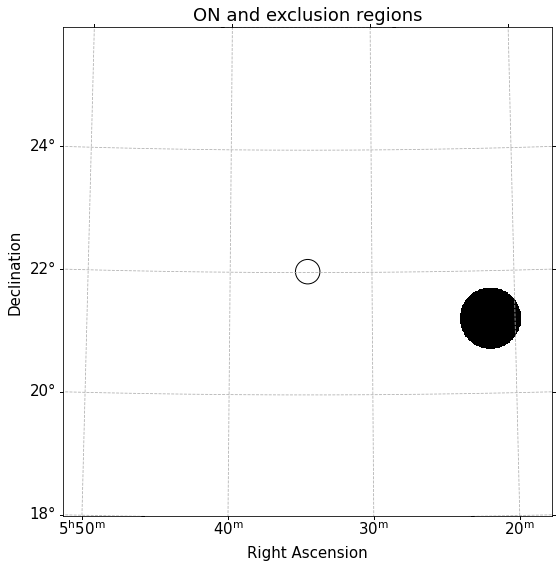

In [5]:
# === Settings ===
exclusion_position_name = 'RGB J0521+212'

# exclusion_position_lon = u.Quantity(183.604, u.deg)
# exclusion_position_lat = u.Quantity(-8.708, u.deg)
# exclusion_position_frame = 'galactic'

exclusion_region_radius = u.Quantity(0.5, u.deg)

# === Main ===
if exclusion_position_name is not None:
    print(f'Get the exclusion position from the source name: {exclusion_position_name}\n')
    exclusion_position = SkyCoord.from_name(exclusion_position_name)
    exclusion_position = exclusion_position.transform_to('icrs')
else:
    print('Set the exclusion position with the input values...\n')
    exclusion_position = SkyCoord(
        exclusion_position_lon, exclusion_position_lat, frame=exclusion_position_frame,
    )
    
exclusion_region = CircleSkyRegion(center=exclusion_position, radius=exclusion_region_radius)

print(exclusion_region)

geom = WcsGeom.create(
    npix=(800, 800), binsz=0.01,
    skydir=target_position, proj='TAN', frame='icrs',
)

exclusion_mask = ~geom.region_mask([exclusion_region])

# Plot the region:
plt.figure()

ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor='black')

ax.set_title('ON and exclusion regions')
ax.grid()

# Run data reduction chain

In [6]:
# === Settings ===
energy_reco_min = 0.01
energy_reco_max = 10
n_bins_reco = 5

energy_true_min = 0.01
energy_true_max = 100
n_bins_true = 5

# === Main ===
energy_axis = MapAxis.from_energy_bounds(
    energy_reco_min, energy_reco_max, nbin=n_bins_reco, per_decade=True, unit='TeV', name='energy',
)

energy_axis_true = MapAxis.from_energy_bounds(
    energy_true_min, energy_true_max, nbin=n_bins_true, per_decade=True, unit='TeV', name='energy_true',
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

# Define the SpectrumDatasetMaker, assuming tha the input is point-like IRFs.
# Even if the "use_region_center" is set to True, there is the following warning but is safely ignored:
# "MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate"
# This issue has been already fixed in the master branch and it will not appear in the coming version of gammapy:

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=['counts', 'exposure', 'edisp'], use_region_center=True,
)

bkg_maker = ReflectedRegionsBackgroundMaker(
    exclusion_mask=exclusion_mask, min_distance=u.Quantity(100, u.deg), max_region_number=1,
)

safe_mask_maker = SafeMaskMaker(methods=['aeff-max'], aeff_percent=10)

print(dataset_maker)

SpectrumDatasetMaker
--------------------

  selection               : {'edisp', 'exposure', 'counts'}
  containment_correction  : False
  background_oversampling : None
  use_region_center       : True



In [ ]:
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)
    
    datasets.append(dataset_on_off)

print(datasets)

MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


In [ ]:
plt.figure()

ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor='black')

plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

ax.set_title('ON/OFF and exclusion regions')
ax.grid()

# Source statistics

In [ ]:
info_table = datasets.info_table(cumulative=True)

In [ ]:
info_table

In [ ]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

# Livetime vs N events:
plt.subplot2grid(grid, (0, 0))
plt.title('Evolution of the number of events')
plt.xlabel('Livetime [h]')
plt.ylabel('Number of events')

plt.plot(
    info_table['livetime'].to('h'), info_table['excess'],
    marker='o', linestyle='--', label='Excess'
)

plt.plot(
    info_table['livetime'].to('h'), info_table['background'],
    marker='o', linestyle='--', label='Background',
)

plt.grid()
plt.legend()

# Livetime vs Sqrt(TS):
plt.subplot2grid(grid, (0, 1))
plt.title('Evolution of the significance')
plt.xlabel('Livetime [h]')
plt.ylabel('Sqrt(TS)')

plt.plot(info_table['livetime'].to('h'), info_table['sqrt_ts'], marker='o', linestyle='--')

plt.grid()

# Fit spectrum

In [ ]:
# === Settings ===
model_function = LogParabolaSpectralModel

parameters = {
    'amplitude': u.Quantity(5e-12, u.Unit('cm-2 s-1 TeV-1')),
    'alpha': u.Quantity(2),
    'beta': u.Quantity(0.1),
    'reference': u.Quantity(1, u.TeV),
}

model_name = 'crab'

# === Main ===
spectral_model = model_function(**parameters)
model = SkyModel(spectral_model=spectral_model, name=model_name)

datasets.models = [model]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

model_best_joint = model.copy()

print(result_joint)

In [ ]:
datasets.models.to_parameters_table()

In [ ]:
for i_data, dataset in enumerate(datasets):
    
    plt.figure()

    ax_spectrum, ax_residuals = datasets[i_data].plot_fit()

    ax_spectrum.set_title(f'Run{dataset.name}')
    ax_spectrum.set_ylabel('Number of events')
    ax_spectrum.set_ylim(0.2, 200)
    ax_spectrum.grid()

    plt.setp(ax_spectrum.get_xticklabels(), visible=False)

    ax_residuals.grid()

    plt.subplots_adjust(hspace=0)

# Compute flux points

In [ ]:
# === Settings ===
energy_edges = u.Quantity(np.logspace(-1, 1, 11), u.TeV)

# === Main ===
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source='crab', selection_optional='all',
)

flux_points = fpe.run(datasets=datasets)
flux_points_dataset = FluxPointsDataset(data=flux_points, models=model_best_joint)

In [ ]:
flux_points.to_table(sed_type='e2dnde', formatted=True)

In [ ]:
plt.figure()

plot_kwargs = {
    'sed_type': 'e2dnde',
    'yunits': u.Unit('erg cm-2 s-1'),
}

# Plot the computed flux points:
ax = flux_points_dataset.plot_spectrum(kwargs_model=plot_kwargs)

# Plot the MAGIC reference curve:
create_crab_spectral_model('magic_lp').plot(
    ax=ax, energy_bounds=u.Quantity([0.1, 10], u.TeV),
    label='MAGIC LP (JHEAp 2015)', **plot_kwargs,
)

ax.set_title('Spectral Energy Distribution')
ax.set_ylabel('$E^2dN/dE$  [erg cm$^{-2}$ s$^{-1}$]')
ax.grid(which='both')
ax.legend()